# ScipyMinimize 

In [1]:
import os
from math import pi
from time import time



# os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"  # Use only the first GPU
# from autocvd import autocvd
# autocvd(num_gpus = 1)

os.environ['JAX_PLATFORM_NAME'] = 'cpu'


from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)
import jaxopt

import numpy as np
from astropy import units as u
from astropy import constants as c


# from ott.tools.unreg import wassdis_p


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, NFW_POTENTIAL, PlummerParams, MN_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity
from odisseo.utils import E_tot, Angular_momentum
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=1_000, 
                          return_snapshots=False, 
                          num_snapshots=100, 
                          num_timesteps=100, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme= DIRECT_ACC_MATRIX,
                        #   double_map=True,
                          batch_size=100,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (2* u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=False, num_snapshots=100, fixed_timestep=True, num_timesteps=100, softening=np.float64(0.010000000000000002), integrator=0, diffrax_solver=0, acceleration_scheme=2, batch_size=100, double_map=False, external_accelerations=(0,), differentation_mode=1, num_checkpoints=100)
SimulationParams(G=1, t_end=np.float64(1.3414174818406912), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(1.0)), NFW_params=NFWParams(Mvir=np.float64(10000.0), r_s=np.float64(2.0), c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(alpha=-1.8, r_c=1.9))


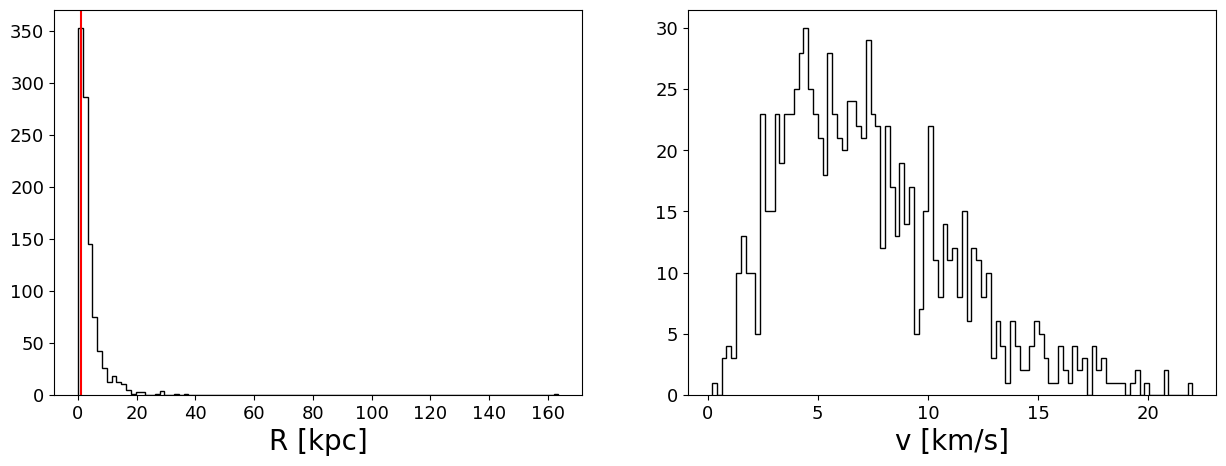

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [5]:
@jit
def mass_enclosed_NFW(R, params):
    """
    Compute the mass of the NFW potential at a given radius R.

    ref: wikipedia
    """
    c = params.NFW_params.c
    Mvir = params.NFW_params.Mvir
    r_s = params.NFW_params.r_s
    rho_0 = (Mvir / (4*jnp.pi * r_s**3)) * (jnp.log(1+c) - c/(1+c))**-1

    return 4*jnp.pi*rho_0*r_s**3 * (jnp.log(1 + R/r_s) - R/(r_s + R))



In [6]:
# radial distance of the center of mass
rp=200*u.kpc.to(code_units.code_length)

#sampling the center of mass on the sphere
key = random.PRNGKey(42)
num_samples = 1  # Number of positions to generate
pos = sample_position_on_sphere(key, rp, num_samples)
vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
state_com = construct_initial_state(pos, vel)

e = jnp.array(0.5)
inclination = jnp.radians(30)  # 30-degree inclination
mass1 = mass_enclosed_NFW(rp, params)
mass2 = params.Plummer_params.Mtot 
_, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                mass2=mass2,
                                rp=rp,
                                e=e,
                                params=params)
bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
vel = inclined_circular_velocity(pos, bulk_velocity_modulus, inclination)


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos
velocities = velocities + vel
initial_state = construct_initial_state(positions, velocities)

#evolve 
target_state = time_integration(initial_state, mass, config, params)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]
distribution_r_target = jnp.linalg.norm(target_state[:, 0], axis=1)
hist_target, _ = jnp.histogram(distribution_r_target, bins=100, range=(0, (25*u.kpc).to(code_units.code_length).value))


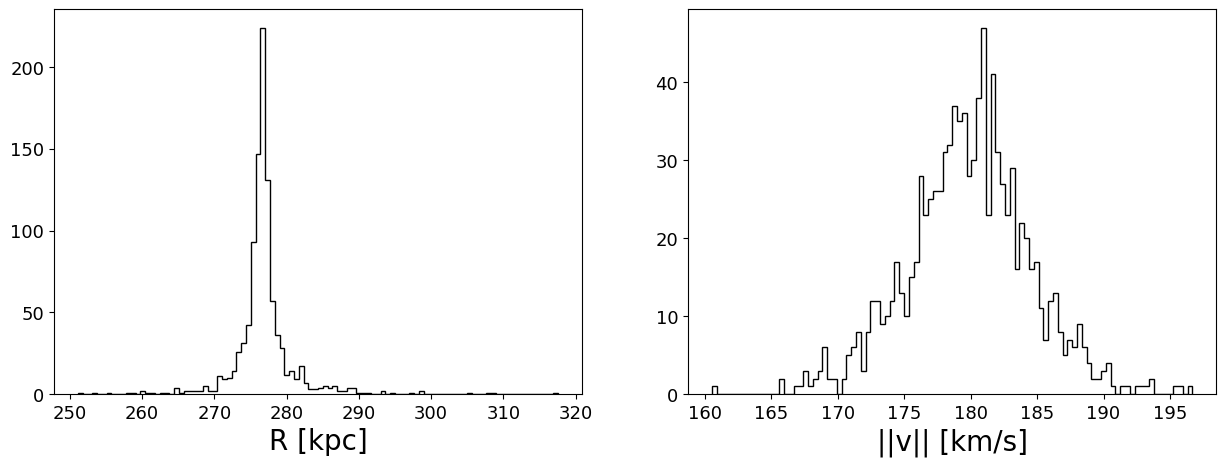

In [7]:
#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((distribution_r_target * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('||v|| [km/s]')
plt.show()



Text(0.5, 0.92, 'Target state')

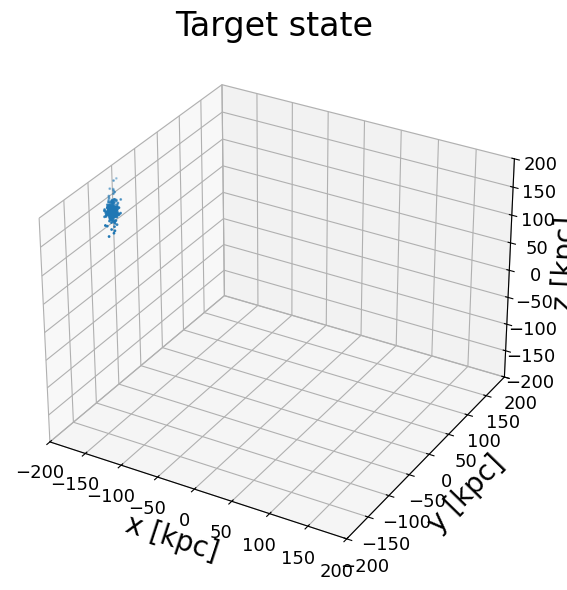

In [8]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(target_state[:, 0, 0] * code_units.code_length.to(u.kpc), 
           target_state[:, 0, 1] * code_units.code_length.to(u.kpc), 
           target_state[:, 0, 2] * code_units.code_length.to(u.kpc), s=1)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_zlabel('z [kpc]')
ax.set_xlim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
ax.set_ylim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
ax.set_zlim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
ax.set_title('Target state')

In [9]:
positions_target = target_state[:, 0]
velocities_target = target_state[:, 1]
bins = 100
hist_pos_target, _ = jnp.histogramdd(positions_target, bins=bins, range=[[-rp, rp], [-rp, rp], [-rp, rp]], )
hist_pos_target = hist_pos_target / jnp.sum(hist_pos_target)  # Normalize the histogram
hist_vel_target, _ = jnp.histogramdd(velocities_target, bins=bins, range=[[-50., 50.], [-50., 50.], [-50., 50.]], )
hist_vel_target = hist_vel_target / jnp.sum(hist_vel_target)  # Normalize the 

energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[:, 2]

energy_target_hist, _ = jnp.histogram(energy_target, bins=100, range=(-1, 1))

Lz_target_hist, _ = jnp.histogram(Lz_target, bins=100, range=(-1, 1))

In [14]:
@jit
def loss_function(M_NFW, mass, hist_pos_target, hist_vel_target):
    new_params = params._replace(
    NFW_params=params.NFW_params._replace(
        Mvir=M_NFW * u.Msun.to(code_units.code_mass)
    ))

    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=new_params, config=config)

    # radial distance of the center of mass
    rp=200*u.kpc.to(code_units.code_length)

    #sampling the center of mass on the sphere
    key = random.PRNGKey(43)
    num_samples = 1  # Number of positions to generate
    pos = sample_position_on_sphere(key, rp, num_samples)
    vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
    state_com = construct_initial_state(pos, vel)

    e = jnp.array(0.5)
    inclination = jnp.radians(30)  # 30-degree inclination
    mass1 = mass_enclosed_NFW(rp, new_params)
    mass2 = new_params.Plummer_params.Mtot 
    _, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                    mass2=mass2,
                                    rp=rp,
                                    e=e,
                                    params=new_params)
    bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
    vel = inclined_circular_velocity(pos, bulk_velocity_modulus, inclination)


    # Add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos
    velocities = velocities + vel
    initial_state = construct_initial_state(positions, velocities)

    final_state = time_integration(initial_state, mass, config, new_params)
    # position and velocity don't work
    final_state_pos = final_state[:, 0]
    final_state_vel = final_state[:, 1]

    kde_pos = jax.scipy.stats.gaussian_kde(final_state_pos.T)
    pos_lim = jnp.linspace(-rp, rp, 100)
    mx, my, mz = jnp.meshgrid(pos_lim, pos_lim, pos_lim, indexing='ij')
    counts_pos = kde_pos.evaluate(jnp.array([mx.reshape(-1),
                                         my.reshape(-1),
                                         mz.reshape(-1)])).reshape((100, 100, 100))
    counts_pos /= jnp.sum(counts_pos)


    kde_vel = jax.scipy.stats.gaussian_kde(final_state_vel.T)
    vel_lim = jnp.linspace(-50., 50., 100)
    vx, vy, vz = jnp.meshgrid(vel_lim, vel_lim, vel_lim, indexing='ij')
    counts_vel = kde_vel.evaluate(jnp.array([vx.reshape(-1),
                                         vy.reshape(-1),
                                         vz.reshape(-1)])).reshape((100, 100, 100))
    counts_vel /= jnp.sum(counts_vel)

    return jnp.sum((counts_pos - hist_pos_target) ** 2) + jnp.sum((counts_vel - hist_vel_target) ** 2)

    # energy, Lz = E_tot(final_state, mass, config, params), Angular_momentum(final_state, mass, )[:, 2]
    # kde_energy = jax.scipy.stats.gaussian_kde(energy)
    # energy_lim = jnp.linspace(-1.0, 1.0, 100)
    # m_energy = jnp.meshgrid(energy_lim, indexing='ij')
    # counts_energy = kde_energy.evaluate(jnp.array([m_energy[0].reshape(-1)]))
    # counts_energy /= jnp.sum(counts_energy)

    # kde_Lz = jax.scipy.stats.gaussian_kde(Lz)
    # Lz_lim = jnp.linspace(-1.0, 1.0, 100)
    # m_Lz = jnp.meshgrid(Lz_lim, indexing='ij')
    # counts_Lz = kde_Lz.evaluate(jnp.array([m_Lz[0].reshape(-1)]))
    # counts_Lz /= jnp.sum(counts_Lz)
    

    # return jnp.sum((counts_energy - energy_target_hist )**2) + jnp.sum((counts_Lz - Lz_target_hist)**2)
         

In [15]:
optimizer = jaxopt.ScipyMinimize(
  method="l-bfgs-b", fun=loss_function, tol=1e-10
)


sol = optimizer.run(0.5*1e11, mass, hist_pos_target, hist_vel_target)

In [ ]:
sol.params.shape

()

In [16]:
sol

OptStep(params=Array(5.e+10, dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(nan, dtype=float64, weak_type=True), success=False, status=2, iter_num=0, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(21, dtype=int32), num_jac_eval=Array(21, dtype=int32), num_hess_eval=Array(0, dtype=int32)))

In [ ]:
integrated_state = time_integration(initial_state, mass, config, params)


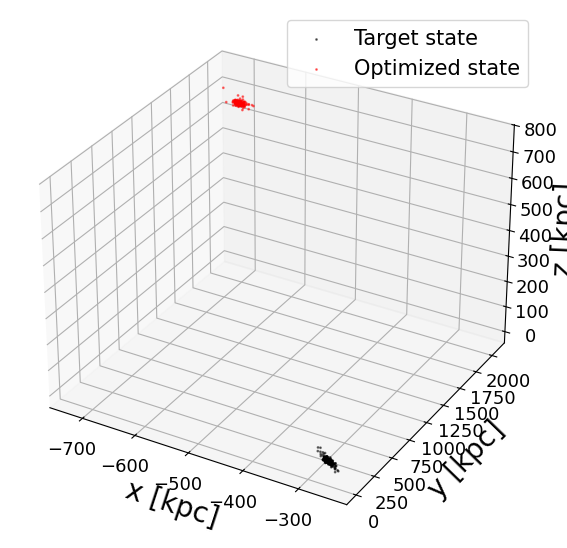

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(target_state[:, 0, 0] * code_units.code_length.to(u.kpc), 
           target_state[:, 0, 1] * code_units.code_length.to(u.kpc), 
           target_state[:, 0, 2] * code_units.code_length.to(u.kpc), 
           s=1,
           label='Target state', 
           color='k', 
           alpha=0.5)
ax.scatter(integrated_state[:, 0, 0] * code_units.code_length.to(u.kpc),
            integrated_state[:, 0, 1] * code_units.code_length.to(u.kpc), 
            integrated_state[:, 0, 2] * code_units.code_length.to(u.kpc), 
            s=1, 
            label='Optimized state',
            color='r',
            alpha=0.5)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_zlabel('z [kpc]')
# ax.set_xlim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
# ax.set_ylim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
# ax.set_zlim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
ax.legend()


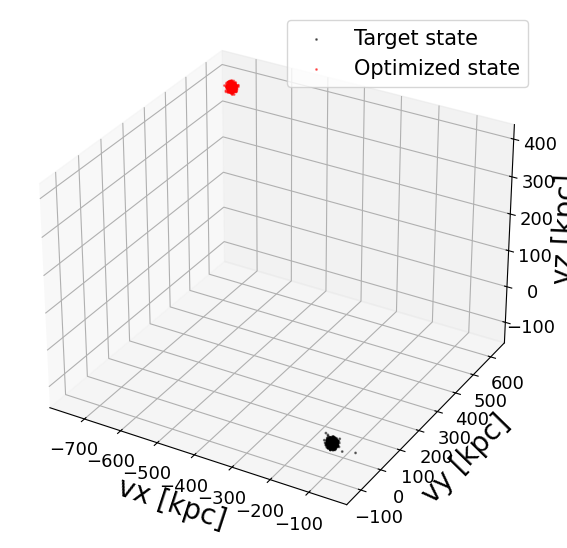

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(target_state[:, 1, 0] * code_units.code_velocity.to(u.km/u.s), 
           target_state[:, 1, 1] * code_units.code_velocity.to(u.km/u.s), 
           target_state[:, 1, 2] * code_units.code_velocity.to(u.km/u.s), 
           s=1,
           label='Target state', 
           color='k', 
           alpha=0.5)
ax.scatter(integrated_state[:, 1, 0] * code_units.code_velocity.to(u.km/u.s),
            integrated_state[:, 1, 1] * code_units.code_velocity.to(u.km/u.s), 
            integrated_state[:, 1, 2] * code_units.code_velocity.to(u.km/u.s), 
            s=1, 
            label='Optimized state',
            color='r',
            alpha=0.5)
ax.set_xlabel('vx [kpc]')
ax.set_ylabel('vy [kpc]')
ax.set_zlabel('vz [kpc]')
ax.legend()


# Optimize also for the parameters !

In [ ]:
@jit
def loss_function(input, mass, hist_pos_target, hist_vel_target):
    initial_state, params = input
    final_state = time_integration(initial_state, mass, config, params)
    final_state_pos = final_state[:, 0]
    final_state_vel = final_state[:, 1]

    hist_pos, _ = jnp.histogramdd(final_state_pos, bins=bins, range=[[-rp, rp], [-rp, rp], [-rp, rp]], density=True)
    hist_vel, _ = jnp.histogramdd(final_state_vel, bins=bins, range=[[-50., 50.], [-50., 50.], [-50., 50.]], density=True) 
    loss_pos = jnp.sum((hist_pos - hist_pos_target) ** 2)
    loss_vel = jnp.sum((hist_vel - hist_vel_target) ** 2)
    return loss_pos + loss_vel
         
optimizer = jaxopt.ScipyMinimize(
  method="l-bfgs-b", fun=loss_function, tol=1e-8
)

sol = optimizer.run((initial_state, params mass, hist_pos_target, hist_vel_target)
sol.params.shape
integrated_state = time_integration(sol.params, mass, config, params)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(target_state[:, 0, 0] * code_units.code_length.to(u.kpc), 
           target_state[:, 0, 1] * code_units.code_length.to(u.kpc), 
           target_state[:, 0, 2] * code_units.code_length.to(u.kpc), 
           s=1,
           label='Target state', 
           color='k', 
           alpha=0.5)
ax.scatter(integrated_state[:, 0, 0] * code_units.code_length.to(u.kpc),
            integrated_state[:, 0, 1] * code_units.code_length.to(u.kpc), 
            integrated_state[:, 0, 2] * code_units.code_length.to(u.kpc), 
            s=1, 
            label='Optimized state',
            color='r',
            alpha=0.5)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_zlabel('z [kpc]')
ax.set_xlim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
ax.set_ylim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
ax.set_zlim(-rp* code_units.code_length.to(u.kpc), rp* code_units.code_length.to(u.kpc))
ax.legend()

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(target_state[:, 1, 0] * code_units.code_velocity.to(u.km/u.s), 
           target_state[:, 1, 1] * code_units.code_velocity.to(u.km/u.s), 
           target_state[:, 1, 2] * code_units.code_velocity.to(u.km/u.s), 
           s=1,
           label='Target state', 
           color='k', 
           alpha=0.5)
ax.scatter(integrated_state[:, 1, 0] * code_units.code_velocity.to(u.km/u.s),
            integrated_state[:, 1, 1] * code_units.code_velocity.to(u.km/u.s), 
            integrated_state[:, 1, 2] * code_units.code_velocity.to(u.km/u.s), 
            s=1, 
            label='Optimized state',
            color='r',
            alpha=0.5)
ax.set_xlabel('vx [kpc]')
ax.set_ylabel('vy [kpc]')
ax.set_zlabel('vz [kpc]')
ax.legend()
